## 1.Reliability Fusion Map (RFM)

<br>

1. `matrix` is global variable from csv file <br>
    `f1, f2, f3...` is CNN confidence vector; <br>
    `p` = CNN predict label; <br>
    `y` = label of patch; <br>
    `texture_quality` = patch texture quality factor, see formula(2) in paper
    <hr>
    
2. Fusion step: `filter_texture()`->`fushion_map()`->`fusion_denisty()`; <br>
    `filter_texture()`: filter low texture patch predictions of CNN, we set threshold_texture=0;<br>
    `fushion_map()`: fusion step1, see formula(3) in paper; <br>
    `fusion_denisty()`: fusion step2, see formula(4), (5) in paper; <br>
    <hr>

3. Output matrix structure is the same as input matrix <br>
    <hr>


## 2.About

This is tampering localization experiment for RFM algorithm (see experiment 2-1 in paper). <br>


> $matrix=[f1, f2, f3, f4, f5... p, y, texture_quality]

In [236]:
import os, math, seaborn as sns, numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib.image as mpimg
from collections import Counter
sns.set()

# matrix=[f1, f2, f3, f4, f5, p, y, texture_quality]

In [221]:
root_path = "/data/experiment"
scope_name = "pre-train_32x32" # The input csv is 64x64 overlap patches, with step of 32

csv_root = os.path.join(root_path, scope_name)
ground_root = os.path.join(root_path, "ground")
splice_root = os.path.join(root_path, "splicing")

In [222]:
def filter_texture(matrix, label, threshold=0.4):
    '''
    Filter low texture patches
    @matrix=[f1, f2, f3, f4, f5, p, y, texture_quality]
    '''
    # get placeholder
    flag = (matrix[:, 7] < threshold)
    matrix[flag, :5] = 0
    matrix[flag, label] = 1
    return matrix

def fushion_map(matrix, w, h):
    '''
    Fusion step1: F & Q
    After fusion，w=w-1, h=h-1, texture_quality，label=4个取投票
    @matrix=[f1, f2, f3, f4, f5, p, y, texture_quality]
    '''
    matrix = np.reshape(matrix, (h, w, -1))
    result = np.zeros((h-1, w-1, 7))
    offset = [[0,0], [0,1], [1,0], [1,1]]
    
    for j in range(h - 1):
        for i in range(w - 1):
            # temp matrix
            tmp_matrix = np.zeros([5])
            total = matrix[j, i, 7] + matrix[j, i+1, 7] + matrix[j+1, i, 7] + matrix[j+1, i+1, 7]
            for p in offset:
                tmp_matrix += (matrix[j+p[0], i+p[1], :5]) * (matrix[j+p[0], i+p[1], 7] / total)
            
            # append result to F confidence
            result[j, i, :5] = tmp_matrix
            result[j, i, 5] = np.array(np.argmax(result[j, i, :5]), dtype=np.int32)
            
            label_map = []
            for p in offset:
                label_map.append(int(matrix[j+p[0], i+p[1], 6]))
            result[j, i, 6] = Counter(label_map).most_common()[0][0]
    return np.reshape(result, ((w-1) * (h-1), 7))

def fusion_denisty(matrix, w, h, label, threshold=0.6):
    '''
    Fusion step2: R & ρ
    @matrix=[f1, f2, f3, f4, f5, p, y, texture_quality]
    '''
    flag = np.where(matrix[:, 5] != label)
    matrix = np.reshape(matrix, (h, w, -1))
    source_matrix = matrix.copy()
    
    offset = [
        [-1, -1], [-1, 0], [-1, 1], 
        [0, -1], [0, 1], 
        [1, -1], [1, 0], [1, 1]
    ]
    for index in list(flag[0]):
        x = int(index % w)
        y = int(index / w)
        
        length, cnt = 0, 0
        for p in offset:
            _x = x + p[1]
            _y = y + p[0]
            
            # 检测是否在边界，如果不是边界要计算
            if (_x >= 0) and (_y >= 0) and (_x < w) and (_y < h):
                cnt += 1
                # add check length+1
                if source_matrix[_y][_x][5] != label:
                    length += 1

        # update confidence & label
        if float(length / cnt) < threshold:
            matrix[y, x, :5] = 0
            matrix[y, x, label] = 1
            matrix[y, x, 5] = label
    return np.reshape(matrix, (w*h, -1))

def show_map(matrix, w, h, label, threshold=0):
    '''
    show hotmap
    @matrix=[f1, f2, f3, f4, f5, p, y]
    '''
    plt.clf()
    label_list = np.ones([w*h], dtype=np.int32) * label
    predict_list = matrix[0: w*h, 5]
    
    diff_matrix = np.array(np.abs(label_list - predict_list), dtype=np.bool) * 1
    conf_matrix = np.max(matrix[:, 0:5], axis=1)
    
    list_matrix = np.multiply(conf_matrix, diff_matrix)
    list_matrix[list_matrix < threshold] = 0
    
    f, ax = plt.subplots(figsize=(16, 10))
    xmap = np.reshape(list_matrix, (h, w))
    return sns.heatmap(xmap, linewidths=.01, cmap='YlGnBu')

def split_ground(image, w, h, label1, label2, shape=(32, 32), threshold=0.8):
    '''
    generate label of 32x32 patch from ground truth images
    @param image: ground truth image, 0=forged, 255=pristine (pixel unit)
    @param mark_x/mark_y: matrix coordinates of forged region
    @return patch_label, mark_x, mark_y
    '''
    flag = True
    w, h, size = int(w / shape[0] - 1), int(h / shape[1] - 1), shape[0] * shape[1]
    result = np.ones([h - 1, w - 1]) * label2
    mark_x, mark_y = [w - 1, 0], [h - 1, 0]
    
    for j in range(1, h - 1):
        y = j * shape[1]
        for i in range(1, w - 1):
            x = i * shape[0]
            # scan all patches
            check = (image[y: y + shape[1], x: x + shape[0], 0].copy() / 255).astype(np.int32)
            # take a threshold to mark patch as forged
            if 1 - float(np.sum(check) / size) > threshold:
                flag = False
                result[j - 1, i - 1] = label1
                mark_x[0] = min(mark_x[0], i - 1)
                mark_x[1] = max(mark_x[1], i - 1)
                mark_y[0] = min(mark_y[0], j - 1)
                mark_y[1] = max(mark_y[1], j - 1)

    # without find forged patches, mark mark_x/mark_y as full image
    if flag:
        t = mark_y[0]
        mark_y[0] = mark_y[1]
        mark_y[1] = t
        t = mark_x[0]
        mark_x[0] = mark_x[1]
        mark_x[1] = t
    
    # @result=[y1, y2, y3...], mark_x=[min_x, max_x], mark_y=[min_y, max_y]
    return np.reshape(result, ((w-1) * (h-1))), mark_x, mark_y

1 Kodak_M1063_0_9565_Nikon_D200_0_15080_1540019393_3872_2592.csv


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


1.0 0.976598234230401
2 Kodak_M1063_0_9457_Nikon_D200_0_15062_1540106699_3872_2592.csv
0.986013986013986 0.9902138070418041
3 Kodak_M1063_0_9585_Nikon_D200_0_15070_1540019711_3872_2592.csv
0.9917695473251029 0.9989362833741091
4 Sony_DSC-H50_0_46953_Rollei_RCP-7325XS_0_42204_1540042188_3072_2304.csv
0.7208333333333333 0.9261398176291793
5 Kodak_M1063_0_9457_Rollei_RCP-7325XS_0_42215_1540044821_3072_2304.csv
1.0 0.8855623100303951
6 Sony_DSC-H50_0_47027_Rollei_RCP-7325XS_0_42269_1540042378_3072_2304.csv


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


1.0 0.9790273556231003
7 Kodak_M1063_0_9583_Rollei_RCP-7325XS_0_42218_1540046473_3072_2304.csv
0.7277777777777777 0.9194528875379939
8 Kodak_M1063_0_9557_Nikon_D200_0_15046_1540018875_3872_2592.csv
0.762987012987013 0.9219231996596107
9 Rollei_RCP-7325XS_0_42208_Sony_DSC-H50_0_46903_1540023403_3456_2592.csv
0.9 0.960831144017196
10 Nikon_D200_0_15026_Kodak_M1063_0_9532_1540040877_3664_2748.csv
0.9247311827956989 0.977947504302926
11 Nikon_D200_0_15026_Rollei_RCP-7325XS_0_42222_1540022878_3072_2304.csv
0.8752052545155994 0.965501519756839
12 Sony_DSC-H50_0_46953_Agfa_Sensor505-x_0_1628_1540107258_2592_1944.csv
0.7037037037037037 0.8332605848974247
13 Kodak_M1063_0_9525_Nikon_D200_0_15046_1540018343_3872_2592.csv
0.9919786096256684 0.9986171683863418
14 Kodak_M1063_0_9583_Rollei_RCP-7325XS_0_42316_1540045751_3072_2304.csv
0.7142857142857143 0.920516717325228
15 Sony_DSC-H50_0_47027_Rollei_RCP-7325XS_0_42219_1540042280_3072_2304.csv
0.9477611940298507 0.9747720364741641
16 Nikon_D200_0_14

1.0 0.9983864027538726
85 Sony_DSC-H50_0_46951_Agfa_Sensor505-x_0_1627_1540124824_2592_1944.csv
1.0 0.9738105630728939
86 Kodak_M1063_0_9583_Rollei_RCP-7325XS_0_42322_1540046173_3072_2304.csv
0.9744897959183674 0.9911854103343465
87 Nikon_D200_0_15026_Rollei_RCP-7325XS_0_42204_1540022792_3072_2304.csv
0.8907692307692308 0.9591185410334346
88 Rollei_RCP-7325XS_0_42376_Sony_DSC-H50_0_47027_1540034607_3456_2592.csv
0.8946886446886447 0.9460234057797946
89 Nikon_D200_0_15022_Kodak_M1063_0_9406_1540040371_3664_2748.csv
0.988988988988989 0.9915017211703959
90 Rollei_RCP-7325XS_0_42252_Sony_DSC-H50_0_46912_1540027990_3456_2592.csv
0.735632183908046 0.9353952710771435
91 Nikon_D200_0_15026_Rollei_RCP-7325XS_0_42219_1540022859_3072_2304.csv
0.8792270531400966 0.958966565349544
92 Nikon_D200_0_15022_Rollei_RCP-7325XS_0_42218_1540023080_3072_2304.csv
1.0 0.981306990881459
93 Sony_DSC-H50_0_47027_Agfa_Sensor505-x_0_1629_1540035488_2592_1944.csv
0.9545454545454546 0.9770842426887822
94 Kodak_M1063_

0.9386363636363636 0.9721757821829472
164 Nikon_D200_0_15026_Rollei_RCP-7325XS_0_42219_1540023093_3072_2304.csv
0.9010989010989011 0.9703647416413373
165 Rollei_RCP-7325XS_0_42337_Sony_DSC-H50_0_47030_1540028261_3456_2592.csv
0.9172413793103448 0.969548602818247
166 Sony_DSC-H50_0_47032_Agfa_Sensor505-x_0_1796_1534065258_2592_1944.csv
1.0 0.9934526407682235
167 Kodak_M1063_0_9457_Nikon_D200_0_15072_1540106710_3872_2592.csv
0.9730603448275862 0.9911711520051059
168 Sony_DSC-H50_0_47027_Agfa_Sensor505-x_0_1633_1540035263_2592_1944.csv
0.984375 0.9873417721518988
169 Agfa_Sensor505-x_0_1783_Kodak_M1063_0_9409_1540017720_3664_2748.csv
0.9777777777777777 0.9972030981067126
170 Rollei_RCP-7325XS_0_42252_Sony_DSC-H50_0_46996_1540028177_3456_2592.csv
1.0 0.9226176259851923
171 Kodak_M1063_0_9555_Nikon_D200_0_15074_1540018364_3872_2592.csv
0.796875 0.9808531007339645
172 Sony_DSC-H50_0_47009_Rollei_RCP-7325XS_0_42216_1540044405_3072_2304.csv
0.9704545454545455 0.9965045592705167
173 Sony_DSC-H5

0.9251152073732719 0.9721757821829472
242 Kodak_M1063_0_9585_Rollei_RCP-7325XS_0_42307_1540046614_3072_2304.csv
0.9871794871794872 0.997872340425532
243 Kodak_M1063_0_9579_Rollei_RCP-7325XS_0_42204_1540046979_3072_2304.csv
0.9893333333333333 0.9908814589665653
244 Nikon_D200_0_14908_Kodak_M1063_0_9407_1540038210_3664_2748.csv
0.9981060606060606 0.9939759036144579
245 Agfa_Sensor505-x_0_1633_Kodak_M1063_0_9555_1540013896_3664_2748.csv
0.9914529914529915 0.9984939759036144
246 Sony_DSC-H50_0_46951_Rollei_RCP-7325XS_0_42307_1540043940_3072_2304.csv
0.9602977667493796 0.9653495440729484
247 Sony_DSC-H50_0_47027_Agfa_Sensor505-x_0_1921_1540036400_2592_1944.csv
0.9927536231884058 0.9842863378437363
248 Nikon_D200_0_15026_Kodak_M1063_0_9409_1540040194_3664_2748.csv
0.9125 0.9785929432013769
249 Sony_DSC-H50_0_47004_Agfa_Sensor505-x_0_1673_1540037066_2592_1944.csv
0.9649122807017544 0.9803579223046704
250 Nikon_D200_0_15022_Rollei_RCP-7325XS_0_42194_1540022988_3072_2304.csv
0.8505114083398898 

0.7263736263736263 0.8752279635258359
320 Sony_DSC-H50_0_47447_Rollei_RCP-7325XS_0_42214_1540042779_3072_2304.csv
1.0 0.9949848024316109
321 Kodak_M1063_0_9457_Rollei_RCP-7325XS_0_42218_1540044834_3072_2304.csv
0.9841269841269841 0.9922492401215806
322 Kodak_M1063_0_9457_Rollei_RCP-7325XS_0_42215_1540045888_3072_2304.csv
1.0 0.9153495440729483
323 Nikon_D200_0_15026_Rollei_RCP-7325XS_0_42273_1540022907_3072_2304.csv
0.8641025641025641 0.9439209726443769
324 Nikon_D200_0_15026_Rollei_RCP-7325XS_0_42306_1540022925_3072_2304.csv
0.9923076923076923 0.9937689969604864
325 Kodak_M1063_0_9375_Nikon_D200_0_14906_1540017861_3872_2592.csv
0.6329365079365079 0.9196893947452399
326 Sony_DSC-H50_0_46951_Rollei_RCP-7325XS_0_42214_1540042461_3072_2304.csv
0.9527777777777777 0.9749240121580547
327 Agfa_Sensor505-x_0_1633_Kodak_M1063_0_9403_1540013606_3664_2748.csv
1.0 0.9935456110154905
328 Kodak_M1063_0_9584_Rollei_RCP-7325XS_0_42306_1540046593_3072_2304.csv
0.9927536231884058 0.9965045592705167
329 

0.8981900452488688 0.9414855505134941
397 Agfa_Sensor505-x_0_1858_Kodak_M1063_0_9542_1540017051_3664_2748.csv
0.9829059829059829 0.9945137693631669
398 Nikon_D200_0_15137_Rollei_RCP-7325XS_0_42220_1540023260_3072_2304.csv
0.9732142857142857 0.9907294832826747
399 Sony_DSC-H50_0_46953_Agfa_Sensor505-x_0_1794_1540036907_2592_1944.csv
0.6885964912280702 0.9002618943692711
400 Kodak_M1063_0_9564_Nikon_D200_0_15078_1540019372_3872_2592.csv
0.71875 0.9700031911498777
401 Kodak_M1063_0_9583_Rollei_RCP-7325XS_0_42222_1540046512_3072_2304.csv
1.0 0.9103343465045592


<Figure size 432x288 with 0 Axes>

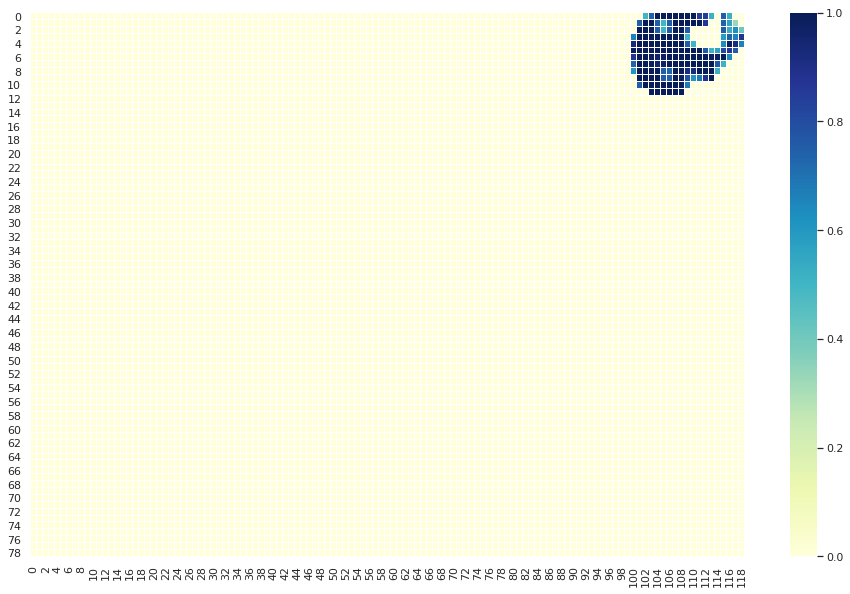

In [232]:
'''
scan all csv files, output localization result
ctype="pre-train_32x32" is forged images CNN csv output;
ctype="pre-train-true_32x32" is pristine images CNN csv output
'''    

cnt, score = 0, 0

def localization_accuracy(threshold=0.009, threshold_texture=0.4, threshold_density=0.6, debug=True):
    global cnt, score
    result = np.zeros([len(os.listdir(csv_root)), 4])
    for name in os.listdir(csv_root):
        #print(cnt + 1, name)

        (_w, _h) = (int(int(name.split("_")[-2])), int(int(name.split("_")[-1].split(".")[-2])))
        (w, h) = int(_w / 32 - 1), int(_h / 32 - 1)

        # label1 = tamper object from, label2 = tamper to image label
        (label1, label2) = get_label(name)
        ground_image = misc.imread(os.path.join(ground_root, name[:-14] + ".jpg"))
        mask_data, mark_x, mark_y = split_ground(ground_image, _w, _h, label1, label2, threshold=threshold_ground)

        # @raw_data=[f1, f2, f3, f4, f5, p, y, texture]
        raw_data = pd.read_csv(os.path.join(root_path, scope_name, name)).values[:w*h, 1:9]    
        # get_label
        label = int(np.argmax(np.bincount(np.array(raw_data[:, 5], dtype=np.int32))))

        # filter texture
        if threshold_texture > 0:
            texture_data = filter_texture(raw_data, label, threshold=threshold_texture)
        else:
            texture_data = raw_data
        
        # fusion step1: F & Q
        fusion_data = fushion_map(texture_data, w, h)
        # fusion step2: R & ρ
        density_data = fusion_denisty(fusion_data, w-1, h-1, label, threshold=threshold_density)
    

        same_count = np.sum(np.equal(mask_data, density_data[:, 5]))
        tamper_same_count, area = compare_tamper(mask_data, density_data[:, 5], mark_x, mark_y, w-1, h-1)
        
        if debug:
            if cnt == 0: show_map(density_data, w-1, h-1, label)
            print("=> local accuracy={:.4f}, golbal accuracy={:.4f}".format(tamper_same_count / area, same_count / mask_data.shape[0]))

        score += tamper_same_count / area
        result[cnt, :] = np.array(list([tamper_same_count, tamper_same_count / area, same_count, same_count / mask_data.shape[0]]))
        cnt += 1
    return result
        
# define threshold, texture, denisty
t, t_texture, t_density = 0.009, 0, 0.6

result = localization_accuracy(t, t_texture, t_density, debug=True)

In [234]:
print("=> average local accuracy={:.5f}".format(np.sum(result[:, 1]) / 401))

=> average local accuracy = 0.91046


In [235]:
print("=> average global accuracy={:.5f}".format(np.sum(result[:, 3]) / 401))

=> average global accuracy = 0.95623
